## Advanced ML: Домашнее задание 3

В этом небольшом домашнем задании мы попробуем улучшить метод Шерлока Холмса. Как известно, в рассказе The Adventure of the Dancing Men великий сыщик расшифровал загадочные письмена, которые выглядели примерно так: 
![The Adventure of the Dancing Men](https://avatars.mds.yandex.net/i?id=447fdc17132d75db777ce124db07d0f4-4303190-images-thumbs&n=13)

Пользовался он для этого так называемым частотным методом: смотрел, какие буквы чаще встречаются в зашифрованных текстах, и пытался подставить буквы в соответствии с частотной таблицей: E — самая частая и так далее.  
В этом задании мы будем разрабатывать более современный и продвинутый вариант такого частотного метода. В качестве корпусов текстов для подсчётов частот можете взять что угодно, но для удобства вот вам [“Война и мир” по-русски и по-английски](https://www.dropbox.com/s/k23enjvr3fb40o5/corpora.zip)


In [297]:
import re
import random
from collections import Counter
from copy import copy
from tqdm import tqdm

import numpy as np
from nltk import ngrams, FreqDist

random.seed(42)

### 1. Реализуйте базовый частотный метод по Шерлоку Холмсу:
* подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить);
* возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе вряд ли сработает), зашифруйте их посредством случайной перестановки символов;
* расшифруйте их таким частотным методом.


In [298]:
ALPHABET = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя "

with open("data/AnnaKarenina.txt", "r", encoding="utf-8") as ak_text, \
     open("data/WarAndPeace.txt", "r", encoding="utf-8") as wap_text:
    text = ak_text.read().lower() + "\n" + wap_text.read().lower()
text = re.sub(f"[^{ALPHABET}]", "", text)
text = re.sub(" +", " ", text)

In [343]:
class FreqDecoder:
    def __init__(self, n=1, alphabet=None):
        self.n = n
        self.alphabet = alphabet or "абвгдеёжзийклмнопрстуфхцчшщъыьэюя "
        self.freq_alphabet = None

    def get_ngrams(self, text, step=1):
        return [text[i : i + self.n] for i in range(0, len(text) - self.n + 1, step)]

    def get_n_gramm_freq(self, text, step):
        text = self._preprocess(text)
        n_grams = self.get_ngrams(text)
        letter_count = Counter(n_grams)
        n_gramm_freq = dict(
            sorted(
                letter_count.items(), key=lambda item: item[1], reverse=True
            )
        )
        return n_gramm_freq


    def _preprocess(self, text):
        text = re.sub(f"[^{self.alphabet}]", "", text)
        text = re.sub(" +", " ", text)
        return text

    def get_freq_alphabet(self, text, step=1):
        letter_freq = self.get_n_gramm_freq(text, step)
        freq_alphabet = [letter for letter in list(letter_freq.keys())]
        return freq_alphabet

    def fit(self, text):
        self.freq_alphabet = self.get_freq_alphabet(text)


    def _encode(self, text):
        text = self._preprocess(text)
        permutation = "".join(random.sample(self.alphabet, len(self.alphabet)))
        transtable = str.maketrans(self.alphabet, permutation)
        encoded_text = text.lower().translate(transtable)
        return encoded_text

    def decode(self, text_encoded):
        text = text_encoded + " " * (len(text_encoded) % self.n)
        text_freq_alphabet = self.get_freq_alphabet(text, step=self.n)
        transtable = {
            text_freq_alphabet[i]: self.freq_alphabet[i]
            for i in range(
                min(len(text_freq_alphabet), len(self.freq_alphabet))
            )
        }
        decoded_text = "".join(
            [transtable.get(i, " ") for i in self.get_ngrams(text, step=self.n)]
        )[:len(text_encoded)]
        return decoded_text

    @staticmethod
    def accuracy(orig_text, decoded_text):
        return (
            np.array(list(orig_text)) == np.array(list(decoded_text))
        ).sum() / len(orig_text)

    def get_encode_decode_report(self, test_text, silent=False):
        text_encoded = self._encode(test_text)
        text_decoded = self.decode(text_encoded)
        dec_accuracy = FreqDecoder.accuracy(test_text, text_decoded)
        if not silent:
            print(f"{'='*15} ИСХОДНЫЙ ТЕКСТ {'='*15}")
            print(test_text)
            print(f"{'='*15} ЗАКОДИРОВАННЫЙ ТЕКСТ {'='*15}")
            print(text_encoded)
            print(f"{'='*15} ДЕКОДИРОВАННЫЙ ТЕКСТ {'='*15}")
            print(text_decoded)
        print(f"{'='*15} accuracy = {round(dec_accuracy, 2)} {'='*15}")


In [344]:
freq_dec = FreqDecoder()
freq_dec.fit(text)

Тестовый текст:

In [345]:
ind = 424242
test_text = text[ind:ind+1000]

Попробуем взять текст из другой эпохи, например что-то из Стругацких:

In [346]:
test_text_modern = """
Зло неистребимо. Никакой человек не способен уменьшить его количество в мире. \
Он может несколько улучшить свою собственную судьбу, но всегда за счет \
ухудшения судьбы других. И всегда будут короли, более или менее жестокие, \
бароны, более или менее дикие, и всегда будет невежественный народ, питающий \
восхищение к своим угнетателям и ненависть к своему освободителю. И все потому, \
что раб гораздо лучше понимает своего господина, пусть даже самого жестокого, \
чем своего освободителя, ибо каждый раб отлично представляет себя на месте господина, \
но мало кто представляет себя на месте бескорыстного освободителя. \
Таковы люди, дон Румата, и таков наш мир.
""".lower()
test_text_modern = re.sub(f'[^{ALPHABET}]', '', test_text_modern)
test_text_modern = re.sub(" +", " ", test_text_modern)

In [347]:
freq_dec.get_encode_decode_report(test_text)

=============== ИСХОДНЫЙ ТЕКСТ ===============
слишком страшно понять свое настоящее положение и он в душе своей закрыл запер и запечатал тот ящик в котором у него находились его чувства к семье то есть к жене и сыну он внимательный отец с конца этой зимы стал особенно холоден к сыну и имел к нему то же подтрунивающее отношение как и к жене а молодой человек обращался он к немуалексей александрович думал и говорил что ни в какой год у него не было столько служебного дела как в нынешний но он не сознавал того что он сам выдумывал себе в нынешнем году дела что это было одно из средств не открывать того ящика где лежали чувства к жене и семье и мысли о них и которые делались тем страшнее чем дольше они там лежали если бы ктонибудь имел право спросить алексея александровича что он думает о поведении своей жены то кроткий смирный алексей александрович ничего не ответил бы а очень бы рассердился на того человека который у него спросил бы про это от этогото и было в выражении лица алексея але

In [348]:
freq_dec.get_encode_decode_report(test_text_modern)

=============== ИСХОДНЫЙ ТЕКСТ ===============
зло неистребимо никакой человек не способен уменьшить его количество в мире он может несколько улучшить свою собственную судьбу но всегда за счет ухудшения судьбы других и всегда будут короли более или менее жестокие бароны более или менее дикие и всегда будет невежественный народ питающий восхищение к своим угнетателям и ненависть к своему освободителю и все потому что раб гораздо лучше понимает своего господина пусть даже самого жестокого чем своего освободителя ибо каждый раб отлично представляет себя на месте господина но мало кто представляет себя на месте бескорыстного освободителя таковы люди дон румата и таков наш мир
=============== ЗАКОДИРОВАННЫЙ ТЕКСТ ===============
бпкнясхйивсъхркняхауакмнщспкжсаняснйцкйкъсянерсяюэхиюнслкнакпхщсйижкнжнрхвснкянркзсинясйакпюакнепещэхиюнйжкчнйкъйижсяяечнйеыюъенякнжйслыунбунйщсинешеыэсях нйеыюъгнывелхшнхнжйслыунъеыеинаквкпхнъкпсснхпхнрсясснзсйикахснъувкягнъкпсснхпхнрсяссныхахснхнжйслыунъеысинясжсз

**Вывод:** Судя по метрике на тестовом тексте совпадения не случайны, но что либо разобрать сложновато.  
На более современном тексте, обученная на текстах Толстова "модель" показывает совсем удручающий результат.  
Изучить как менялся "частотный алфавит" со временем тема отдельной статьи.

### 2. Вряд ли в результате получилась такая уж хорошая расшифровка, разве что если вы брали в качестве тестовых данных целые рассказы. Но и Шерлок Холмс был не так уж прост: после буквы E, которая действительно выделяется частотой, дальше он анализировал уже конкретные слова и пытался угадать, какими они могли бы быть. Я не знаю, как запрограммировать такой интуитивный анализ, так что давайте просто сделаем следующий логический шаг:
* подсчитайте частоты биграмм (т.е. пар последовательных букв) по корпусам;
* проведите тестирование аналогично п.1, но при помощи биграмм  
*Tips: В качестве естественной метрики качества можно взять долю правильно расшифрованных букв или, если хочется совсем математически изощриться, расстояние между двумя перестановками, правильной и полученной из модели; но, честно говоря, в этом задании следить за численными метриками не так уж обязательно, будет и глазами всё видно.* 

In [349]:
freq_dec_bigram = FreqDecoder(n=2)
freq_dec_bigram.fit(text)

In [350]:
freq_dec_bigram.get_encode_decode_report(test_text)

=============== ИСХОДНЫЙ ТЕКСТ ===============
слишком страшно понять свое настоящее положение и он в душе своей закрыл запер и запечатал тот ящик в котором у него находились его чувства к семье то есть к жене и сыну он внимательный отец с конца этой зимы стал особенно холоден к сыну и имел к нему то же подтрунивающее отношение как и к жене а молодой человек обращался он к немуалексей александрович думал и говорил что ни в какой год у него не было столько служебного дела как в нынешний но он не сознавал того что он сам выдумывал себе в нынешнем году дела что это было одно из средств не открывать того ящика где лежали чувства к жене и семье и мысли о них и которые делались тем страшнее чем дольше они там лежали если бы ктонибудь имел право спросить алексея александровича что он думает о поведении своей жены то кроткий смирный алексей александрович ничего не ответил бы а очень бы рассердился на того человека который у него спросил бы про это от этогото и было в выражении лица алексея але

In [351]:
freq_dec_bigram.get_encode_decode_report(test_text_modern)

=============== ИСХОДНЫЙ ТЕКСТ ===============
зло неистребимо никакой человек не способен уменьшить его количество в мире он может несколько улучшить свою собственную судьбу но всегда за счет ухудшения судьбы других и всегда будут короли более или менее жестокие бароны более или менее дикие и всегда будет невежественный народ питающий восхищение к своим угнетателям и ненависть к своему освободителю и все потому что раб гораздо лучше понимает своего господина пусть даже самого жестокого чем своего освободителя ибо каждый раб отлично представляет себя на месте господина но мало кто представляет себя на месте бескорыстного освободителя таковы люди дон румата и таков наш мир
=============== ЗАКОДИРОВАННЫЙ ТЕКСТ ===============
млжефчугюачоуяжефуёвёжсецчлжэчёефчегджгжочфехячфипуюиечтжеёжлуцчгюэжеэеяуачежфеяжнчюефчгёжлиёжехлхцпуюиегэжрегжогюэчффхрегхъиохефжеэгчтъвемвегцчюехьхъпчфукегхъиойеъахтуьеуеэгчтъвеохъхюеёжажлуеожлччеулуеячфчченчгюжёучеоважфйеожлччеулуеячфччеъуёучеуеэгчтъвеохъчюефчэчн

Попробуем увеличить test_text

In [352]:
ind = 40000
test_text_large = text[ind:ind+100000]
freq_dec_bigram.get_encode_decode_report(test_text_large, silent=True)

=============== accuracy = 0.18 ===============


**Вывод:** Качество сильно упало, нужен большой текст, чтобы достигнуть приемлимого качества.  

### 3. Но и это ещё не всё: биграммы скорее всего тоже далеко не всегда работают. Основная часть задания — в том, как можно их улучшить:
* предложите метод обучения перестановки символов в этом задании, основанный на MCMC-сэмплировании, но  по-прежнему работающий на основе статистики биграмм;
* реализуйте и протестируйте его, убедитесь, что результаты улучшились.

Будем использовать Markov chain Monte Carlo метод, а именно Metropolis–Hastings алгоритм:
1. Посчитаем правдоподобие распределения ngram для закодированного текста распределению полученного на "тренировочном" тексте.
2. Произведём случайную перестановку двух букв в закодированном тексте;
3. Посчитаем правдоподобие распределения ngram для получившегося текста распределению полученного на "тренировочном" тексте;
4. Посчитаем отношение правдободобий из пункта 3. и пункта 1., если в результате перестановки правдободобие возросло (отношение > 1), оставляем текст с перестановкой, если нет, то оставляем перестановку с вероятностью равной отношению.  
Повторям эти пункты до тех пор, когда закодированный текст можно будет прочитать.   

In [425]:
class MCMCDecoder:
    def __init__(self, n=1, alphabet=None):
        self.n = n
        self.alphabet = alphabet or "абвгдеёжзийклмнопрстуфхцчшщъыьэюя "
        self.n_gramm_freq = None

    def loglikelihood(self, text):
        text += " " * (len(text) % self.n)
        n_gramm_freq = self.get_n_gramm_freq(text)
        return np.sum(
            [
                count
                * np.log(
                    self.n_gramm_freq.get(ngram, 1 / len(self.alphabet) ** 2)
                )
                for ngram, count in n_gramm_freq.items()
            ]
        )

    def get_ngrams(self, text):
        return [text[i : i + self.n] for i in range(len(text) - self.n + 1)]

    def get_n_gramm_freq(self, text):
        text = self._preprocess(text)
        n_grams = self.get_ngrams(text)
        letter_count = Counter(n_grams)
        n_gramm_freq = dict(
            sorted(
                letter_count.items(), key=lambda item: item[1], reverse=True
            )
        )
        return n_gramm_freq

    def random_permutation(self, text):
        perm_ind = np.random.choice(len(self.alphabet), 2, replace=False)
        permutation = list(self.alphabet)
        permutation[perm_ind[0]], permutation[perm_ind[1]] = (
            permutation[perm_ind[1]],
            permutation[perm_ind[0]],
        )
        permutation = "".join(permutation)
        transtable = str.maketrans(self.alphabet, permutation)
        encoded_text = text.lower().translate(transtable)
        return encoded_text

    def accept_permutation(self, cur_llh, new_llh):
        if new_llh > cur_llh:
            return True
        return np.random.rand() < np.exp(new_llh - cur_llh)

    def _preprocess(self, text):
        text = re.sub(f"[^{self.alphabet}]", "", text)
        text = re.sub(" +", " ", text)
        return text

    def fit(self, text):
        self.n_gramm_freq = self.get_n_gramm_freq(self._preprocess(text))

    def decode(self, text, n_iter=5000, verbose=1000):
        text_decoded_best = copy(text)
        cur_loglikelihood = self.loglikelihood(text)
        best_loglikelihood = cur_loglikelihood
        for iter in tqdm(range(n_iter)):
            new_text = self.random_permutation(copy(text))
            new_loglikelihood = self.loglikelihood(new_text)
            if self.accept_permutation(cur_loglikelihood, new_loglikelihood):
                text = new_text
                cur_loglikelihood = new_loglikelihood
                if cur_loglikelihood > best_loglikelihood:
                    best_loglikelihood = cur_loglikelihood
                    text_decoded_best = copy(text)

            if verbose and iter % verbose == 0:
                print(
                    f"{'='*15} ДЕКОДИРОВАННЫЙ ТЕКСТ НА {iter} ИТЕРАЦИИ  {'='*15}"
                )
                print(text_decoded_best)

        return "".join(text_decoded_best)

    def _encode(self, text):
        text = self._preprocess(text)
        permutation = "".join(random.sample(self.alphabet, len(self.alphabet)))
        transtable = str.maketrans(self.alphabet, permutation)
        encoded_text = text.lower().translate(transtable)
        return encoded_text

    @staticmethod
    def accuracy(orig_text, decoded_text):
        return (
            np.array(list(orig_text)) == np.array(list(decoded_text)[:len(orig_text)])
        ).sum() / len(orig_text)

    def get_encode_decode_report(self, test_text, n_iter=5000, verbose=1000):
        text_encoded = self._encode(test_text)
        text_decoded = self.decode(
            text_encoded, n_iter=n_iter, verbose=verbose
        )
        dec_accuracy = FreqDecoder.accuracy(test_text, text_decoded)
        print(f"{'='*15} ИТОГОВЫЙ ДЕКОДИРОВАННЫЙ ТЕКСТ {'='*15}")
        print(text_decoded)
        print(f"{'='*15} accuracy = {round(dec_accuracy, 2)} {'='*15}")


In [362]:
mcmc_dec = MCMCDecoder(2)
mcmc_dec.fit(text)

In [363]:
mcmc_dec.get_encode_decode_report(test_text)

  5%|▌         | 259/5000 [00:00<00:05, 826.81it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 0 ИТЕРАЦИИ  ===============
дъиуёежыдоалукеыфекьойыдэесыклдоеьбссыфеъепскисыиыекыэыцщусыдэесгытлёа ъытлфсаыиытлфсвлолъыоеоыьбиёыэыёеоеаежыщыксзеыклюециъидйысзеывщэдоэлыёыдсжйсыоеысдойыёыпсксыиыд кщыекыэкижлосъйк гыеосныдыёекнлыроегытиж ыдолъыедемсккеыюеъецскыёыд кщыиыижсъыёыксжщыоеыпсыфецоащкиэлшбссыеокеускисыёлёыиыёыпсксылыжеъецегывсъеэсёыемалблъдьыекыёыксжщлъсёдсгылъсёдлкцаеэивыцщжлъыиызеэеаиъывоеыкиыэыёлёегызецыщыксзеыксым ъеыдоеъйёеыдъщпсмкезеыцсълыёлёыэык ксукигыкеыекыксыдетклэлъыоезеывоеыекыдлжыэ цщж элъыдсмсыэык ксуксжызецщыцсълывоеыроеым ъеыецкеыитыдасцдоэыксыеоёа элойыоезеыьбиёлызцсыъсплъиывщэдоэлыёыпсксыиыдсжйсыиыж дъиыеыкиюыиыёеоеа сыцсълъидйыосжыдоалукссывсжыцеъйусыекиыолжыъсплъиысдъиым ыёоекимщцйыижсъыфалэеыдфаедиойылъсёдсьылъсёдлкцаеэивлывоеыекыцщжлсоыеыфеэсцскииыдэесгыпск ыоеыёаеоёигыджиак гылъсёдсгылъсёдлкцаеэивыкивсзеыксыеоэсоиъым ылыевскйым ыалддсациъдьыклыоезеывсъеэсёлыёеоеа гыщыксзеыдфаедиъым ыфаеыроеыеоыроезеоеыиым ъеыэыэ алп

 25%|██▍       | 1228/5000 [00:01<00:04, 866.89it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 1000 ИТЕРАЦИИ  ===============
емухвоб ертихсо цосчрл екоа сиерочшаа цомопасуа у ос к ныха екоай фивтям фицат у фицадирим рор чшув к воротоб ы саго сищонумуел аго дыкерки в еабла ро аерл в паса у еясы ос ксубирамлсяй ораж е восжи эрой фубя ерим оеозассо щомонас в еясы у убам в сабы ро па цонртысукиюшаа орсохасуа вив у в паса и бомоной дамокав озтишимеч ос в сабыимавеай имавеиснтокуд ныбим у гокотум дро су к вивой гон ы саго са зямо еромлво емыпазсого нами вив к сясахсуй со ос са еофсиким рого дро ос еиб кяныбяким еаза к сясахсаб гоны нами дро эро зямо онсо уф етанерк са орвтякирл рого чшуви гна мапиму дыкерки в паса у еабла у бяему о сущ у воротяа намимуел раб ертихсаа даб номлха осу риб мапиму аему зя вросузынл убам цтико ецтоеурл имавеач имавеиснтокуди дро ос ныбиар о цоканасуу екоай пася ро вторвуй ебутсяй имавеай имавеиснтокуд судаго са оркарум зя и одасл зя тиееатнумеч си рого дамокави воротяй ы саго ецтоеум зя цто эро ор эрогоро у зямо к кя

 44%|████▍     | 2199/5000 [00:02<00:03, 870.19it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 2000 ИТЕРАЦИИ  ===============
илухкод итрахно зончтс ивое наиточшее золоженуе у он в мяхе ивоей факрыл фазер у фазепатал тот чшук в котород я него наюомулуис его пявитва к иедсе то еитс к жене у иыня он внудателсный отец и конца этой фуды итал оиобенно юоломен к иыня у удел к недя то же зомтрянуващшее отнохенуе как у к жене а доломой пеловек обрашалич он к недяалекией алекианмровуп мядал у говорул пто ну в какой гом я него не было итолско иляжебного мела как в нынехнуй но он не иофнавал того пто он иад вымядывал иебе в нынехнед гомя мела пто это было омно уф иремитв не открыватс того чшука гме лежалу пявитва к жене у иедсе у дыилу о ную у которые мелалуис тед итрахнее пед молсхе ону тад лежалу еилу бы ктонубямс удел зраво изроиутс алекиеч алекианмровупа пто он мядает о зовеменуу ивоей жены то кроткуй идурный алекией алекианмровуп нупего не ответул бы а опенс бы раииермулич на того пеловека который я него изроиул бы зро это от этогото у было в вы

 64%|██████▍   | 3204/5000 [00:03<00:02, 810.98it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 3000 ИТЕРАЦИИ  ===============
слищком стращно фондтя свое настодшее фоложение и он в пуще своей закрыл зафер и зафечатал тот дшик в котором у него нахопилися его чувства к семяе то естя к жене и сыну он внимателяный отец с конца этой зимы стал особенно холопен к сыну и имел к нему то же фоптруниваьшее отнощение как и к жене а молопой человек обрашалсд он к немуалексей алексанпрович пумал и говорил что ни в какой гоп у него не было столяко служебного пела как в нынещний но он не сознавал того что он сам выпумывал себе в нынещнем гопу пела что это было опно из срепств не открыватя того дшика гпе лежали чувства к жене и семяе и мысли о них и которые пелалися тем стращнее чем поляще они там лежали если бы ктонибупя имел фраво сфроситя алексед алексанпровича что он пумает о фовепении своей жены то кроткий смирный алексей алексанпрович ничего не ответил бы а оченя бы рассерпилсд на того человека который у него сфросил бы фро это от этогото и было в вы

 85%|████████▌ | 4261/5000 [00:05<00:00, 907.85it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 4000 ИТЕРАЦИИ  ===============
слишком страшно хонять свое настояцее холожение и он в душе своей закрыл захер и захечатал тот яцик в котором у него нафодились его чувства к семье то есть к жене и сыну он внимательный отещ с конща этой зимы стал особенно фолоден к сыну и имел к нему то же ходтруниваюцее отношение как и к жене а молодой человек обрацался он к немуалексей александрович думал и говорил что ни в какой год у него не было столько служебного дела как в нынешний но он не сознавал того что он сам выдумывал себе в нынешнем году дела что это было одно из средств не открывать того яцика где лежали чувства к жене и семье и мысли о ниф и которые делались тем страшнее чем дольше они там лежали если бы ктонибудь имел храво схросить алексея александровича что он думает о ховедении своей жены то кроткий смирный алексей александрович ничего не ответил бы а очень бы рассердился на того человека который у него схросил бы хро это от этогото и было в вы

100%|██████████| 5000/5000 [00:05<00:00, 841.77it/s]

=============== ИТОГОВЫЙ ДЕКОДИРОВАННЫЙ ТЕКСТ ===============
слишком страшно понять свое настоящее положение и он в душе своей закрыл запер и запечатал тот ящик в котором у него находились его чувства к семье то есть к жене и сыну он внимательный отец с конца этой зимы стал особенно холоден к сыну и имел к нему то же подтрунивающее отношение как и к жене а молодой человек обращался он к немуалексей александрович думал и говорил что ни в какой год у него не было столько служебного дела как в нынешний но он не сознавал того что он сам выдумывал себе в нынешнем году дела что это было одно из средств не открывать того ящика где лежали чувства к жене и семье и мысли о них и которые делались тем страшнее чем дольше они там лежали если бы ктонибудь имел право спросить алексея александровича что он думает о поведении своей жены то кроткий смирный алексей александрович ничего не ответил бы а очень бы рассердился на того человека который у него спросил бы про это от этогото и было в выражении л

In [365]:
mcmc_dec.get_encode_decode_report(test_text_modern)

  6%|▌         | 289/5000 [00:00<00:04, 973.90it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 0 ИТЕРАЦИИ  ===============
ряочтеьъдбе ьночтьамаощчюеяопеачтечъиоъо етчкнетйгьдйчефочаояьюеъдпочпчньбечотчноыедчтеъаояйаочкякюгьдйчъпозчъо ъдпетткзчъквй кчточпъефвмчрмчъюедчкэквгетьхчъквй цчвбкфьэчьчпъефвмч квкдчаобояьч ояеечьяьчнетеечыеъдоаьеч мботцч ояеечьяьчнетеечвьаьечьчпъефвмч кведчтепеыеъдпеттцщчтмбовчиьдмзльщчпоъэьлетьечачъпоьнчкфтедмдеяхнчьчтетмпьъдйчачъпоенкчоъпо овьдеязчьчпъечиодонкчюдочбм чфобмрвочякюгечиотьнмедчъпоефочфоъиовьтмчикъдйчвмыечъмнофочыеъдоаофочюенчъпоефочоъпо овьдеяхчь очамывцщчбм чодяьюточибевъдмпяхедчъе хчтмчнеъдечфоъиовьтмчточнмяочадочибевъдмпяхедчъе хчтмчнеъдеч еъаобцъдтофочоъпо овьдеяхчдмаопцчязвьчвотчбкнмдмчьчдмаопчтмгчньб


 26%|██▌       | 1295/5000 [00:01<00:03, 1083.85it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 1000 ИТЕРАЦИИ  ===============
хла неитвкебима нисосай яеларес не тпатабен уменьчивь еза салияетвра р мике ан мажев нетсальса улуячивь траю табтвренную тудьбу на ртездо хо тяев ушудчениг тудьбы дкузиш и ртездо будув сакали балее или менее жетвасие боканы балее или менее дисие и ртездо будев нережетвренный нокад пивоющий ратшищение с траим узневовелгм и неноритвь с траему атрабадивелю и рте паваму ява коб закохда луяче панимоев траеза затпадино путвь доже томаза жетвасаза яем траеза атрабадивелг иба сождый коб авлияна пкедтворлгев тебг но метве затпадино на мола сва пкедтворлгев тебг но метве бетсакытвназа атрабадивелг восары люди дан кумово и восар ноч мик


 47%|████▋     | 2326/5000 [00:02<00:02, 1076.26it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 2000 ИТЕРАЦИИ  ===============
гло неисвпебимо никакой челотек не срособен уменьшивь езо количесвто т мипе он можев несколько улучшивь стою собсвтенную судьбу но тсезда га счев ухудшения судьбы дпузих и тсезда будув кополи более или менее жесвокие бапоны более или менее дикие и тсезда будев нетежесвтенный напод ривающий тосхищение к стоим узневавелям и ненатисвь к стоему остободивелю и тсе ровому чво паб зопагдо лучше ронимаев стоезо зосродина русвь даже самозо жесвокозо чем стоезо остободивеля ибо каждый паб овлично рпедсватляев себя на месве зосродина но мало кво рпедсватляев себя на месве бескопысвнозо остободивеля вакоты люди дон пумава и вакот наш мип


 65%|██████▍   | 3226/5000 [00:03<00:01, 1016.55it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 3000 ИТЕРАЦИИ  ===============
зло неистребимо никакой человек не способен уменьшить его количество в мире он может несколько улучшить свою собственную судьбу но всегда за счет ухудшения судьбы других и всегда будут короли более или менее жестокие бароны более или менее дикие и всегда будет невежественный народ питающий восхищение к своим угнетателям и ненависть к своему освободителю и все потому что раб гораздо лучше понимает своего господина пусть даже самого жестокого чем своего освободителя ибо каждый раб отлично представляет себя на месте господина но мало кто представляет себя на месте бескорыстного освободителя таковы люди дон румата и таков наш мир


 86%|████████▋ | 4316/5000 [00:04<00:00, 983.40it/s] 

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 4000 ИТЕРАЦИИ  ===============
зло неистребимо никакой человек не способен уменьшить его количество в мире он может несколько улучшить свою собственную судьбу но всегда за счет ухудшения судьбы других и всегда будут короли более или менее жестокие бароны более или менее дикие и всегда будет невежественный народ питающий восхищение к своим угнетателям и ненависть к своему освободителю и все потому что раб гораздо лучше понимает своего господина пусть даже самого жестокого чем своего освободителя ибо каждый раб отлично представляет себя на месте господина но мало кто представляет себя на месте бескорыстного освободителя таковы люди дон румата и таков наш мир


100%|██████████| 5000/5000 [00:04<00:00, 1050.83it/s]

=============== ИТОГОВЫЙ ДЕКОДИРОВАННЫЙ ТЕКСТ ===============
зло неистребимо никакой человек не способен уменьшить его количество в мире он может несколько улучшить свою собственную судьбу но всегда за счет ухудшения судьбы других и всегда будут короли более или менее жестокие бароны более или менее дикие и всегда будет невежественный народ питающий восхищение к своим угнетателям и ненависть к своему освободителю и все потому что раб гораздо лучше понимает своего господина пусть даже самого жестокого чем своего освободителя ибо каждый раб отлично представляет себя на месте господина но мало кто представляет себя на месте бескорыстного освободителя таковы люди дон румата и таков наш мир
=============== accuracy = 1.0 ===============


**Вывод:** MCMС метод даёт стопроцентную точность, как на теством тексте взятом из произведений Толстого, так и на тестовом тексте взятом из произвдения других авторов.  

### 4. Расшифруйте сообщение:
```←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏```
Или это (они одинаковые, второй вариант просто на случай проблем с юникодом):
```დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ```


In [412]:
#encoded_text = "დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ"
encoded_text = "←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏"

encoded_alphabet = "".join(set(encoded_text))
encoded_text_ru = encoded_text.translate(
    str.maketrans(
        encoded_alphabet, "".join(random.sample(ALPHABET, len(encoded_alphabet))) # ALPHABET[:len(encoded_alphabet)] # 
    )
)

In [413]:
decoded_text = mcmc_dec.decode(encoded_text_ru, n_iter=100000, verbose=20000)

  0%|          | 348/100000 [00:00<00:57, 1739.98it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 0 ИТЕРАЦИИ  ===============
цнхргпмгпрбряцгуъачлхэумфгрхрг ъжяргуъачлхэумфгяцщнягйгшяъыъгнъъиюцурёгщъяъамфгхцыщъг аъжряляэгнщъаццгпнцыъгпмгпнцгнбцхлхрг алпрхэуъгрг ъхйжряцгчлщнрчлхэумфгилххгслг ънхцбуццгжцяпцаяъцгслблурцгщйанлгкъяёгщъуцжуъгёгуржцыъгуцгъицюлз


 20%|██        | 20272/100000 [00:13<01:08, 1166.66it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 20000 ИТЕРАЦИИ  ===============
если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж


 40%|████      | 40499/100000 [00:26<00:35, 1689.46it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 40000 ИТЕРАЦИИ  ===============
если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж


 60%|██████    | 60344/100000 [00:38<00:22, 1737.56it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 60000 ИТЕРАЦИИ  ===============
если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж


 80%|████████  | 80347/100000 [00:51<00:12, 1621.35it/s]

=============== ДЕКОДИРОВАННЫЙ ТЕКСТ НА 80000 ИТЕРАЦИИ  ===============
если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж


100%|██████████| 100000/100000 [01:03<00:00, 1583.06it/s]


### 5. Бонус: а что если от биграмм перейти к триграммам (тройкам букв) или даже больше? Улучшатся ли результаты? Когда улучшатся, а когда нет? Чтобы ответить на этот вопрос эмпирически, уже может понадобиться погенерировать много тестовых перестановок и последить за метриками, глазами может быть и не видно.

In [435]:
accuracy = []
n_grams_range = list(range(1, 20))
for n in n_grams_range:
    mcmc_decoder = MCMCDecoder(n)
    mcmc_decoder.fit(text)
    decoded_test_text = mcmc_decoder.decode(test_text_modern, n_iter=1000, verbose = None)
    accuracy.append(MCMCDecoder.accuracy(test_text_modern, decoded_test_text))

100%|██████████| 1000/1000 [00:02<00:00, 481.23it/s]


No handles with labels found to put in legend.


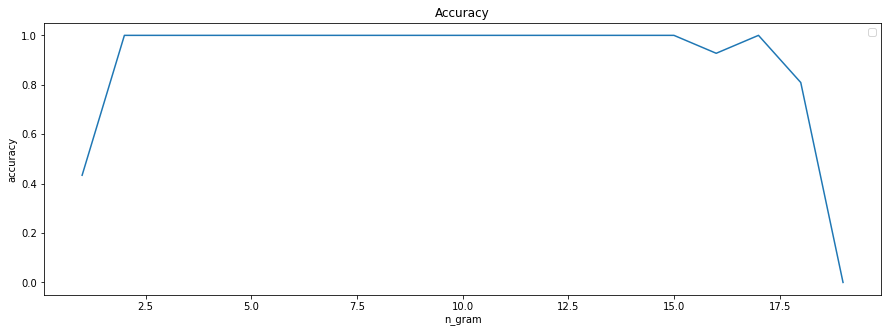

In [436]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, figsize=(15, 5))
axes.set_title("Accuracy")
axes.plot(n_grams_range, accuracy)
axes.set_xlabel("n_gram")
axes.set_ylabel("accuracy")
axes.legend()
plt.show()

**Вывод:** Точность распознования становаится 100% после 2х-грам, и падает после 16-грам, хотя есть подозрение, что если взять тестовый текст большего объёма, качество будет снижаться после большего значения n-грам.

### 6. Бонус: какие вы можете придумать применения для этой модели? Пляшущие человечки ведь не так часто встречаются в жизни (хотя встречаются! и это самое потрясающее во всей этой истории, но об этом я расскажу потом).


* Самое первое что приходит на ум, это применить данный алгоритм в рекомендательных системах или для решения задачи ранжирования.  
На примере фильмов, есть некторое распределение фильмов, которые нравятся пользовтелю, необходимо составить подборку наиболее релевантных фильмов из большого числа фильмов.
* Так же может применяться для восстановления исходного сообещния из демодулированного с ошибками сигнала (например если воздействовала помеха на радиосигнал).
* Я знаю, что применяются нейронные сети для поиска возможных химических совединений при создании материалов с необходимими свойствами, думаю, что для этих целей возможно применение MCMC метода.